In [46]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from camera_intrinsic import get_camera_intrinsics
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone

  # Standard Variablen
Extraktion der Tiefenkarte

## Tiefenkarte und RGB-Daten extrahieren

IPhone Daten

In [47]:
url_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IphoneTestBilder\Küche\Box\IMG_8658.jpg"
output_dir_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten"

rgb_url_Iphone, depth_url_Iphone = transform_jpeg_to_depthmap_iphone(url_Iphone, output_dir_Iphone) #Nutzung unserer Funktion

#Open Images
depth_im_Iphone = Image.open(depth_url_Iphone)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Iphone = Image.open(rgb_url_Iphone)

True
Die Tiefenkarte existiert bereits


Resize RGB image to size of depthmap

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [48]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

Resize Iphone RGB Image

In [49]:
rgb_im_Iphone, dm_width_Iphone, dm_height_Iphone, rgb_width_Iphone, rgb_height_Iphone = resize(rgb_im_Iphone, depth_im_Iphone)

dm_height:768, dm_width:576
 rgb_height:4032, rgb_width:3024
new_rgb_height:768, new_rgb_width:576


Getting the images as numpy arrays for later use

Iphone array

In [50]:
depth_array_Iphone = np.array(depth_im_Iphone)  # getting the depthmap as a numpy array
rgb_array_Iphone = np.array(rgb_im_Iphone)  # getting the rgb image as a numpy array

We need the images as open3d objects or else we can´t create the RGBD image

Iphone o3d object

In [51]:
# convert the arrays to open3d objects Quelle: https://stackoverflow.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array
rgb_o3d_Iphone = o3d.geometry.Image(rgb_array_Iphone)
depth_o3d_Iphone = o3d.geometry.Image(depth_array_Iphone)
#depth_3d = o3d.geometry.Image(np.ascontiguousarray(depth_array_Iphone))

# Processing depth map

Plotting the Iphone depthmap 

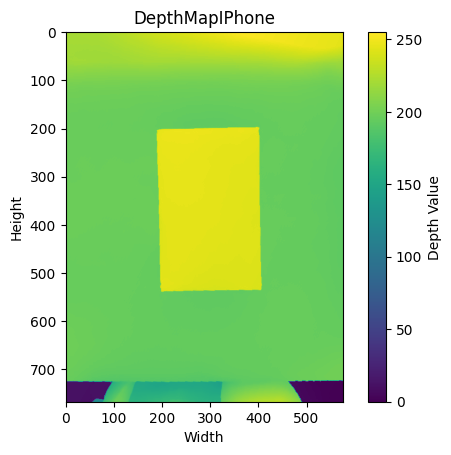

In [53]:
# plotting the depthmap
plt.imshow(depth_array_Iphone)
plt.colorbar(label="Depth Value")
plt.title("DepthMapIPhone")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


## Scale depth map to real values

In [85]:

# Float Min/Max Values aus EXIF-Daten
float_min = 1.293945  # Minimaler Tiefenwert in Metern
float_max = 2.751953  # Maximaler Tiefenwert in Metern

# Umgekehrte Skalierung der Tiefenwerte
depth_map_meters = float_max - (depth_array_Iphone / 255.0) * (float_max - float_min)


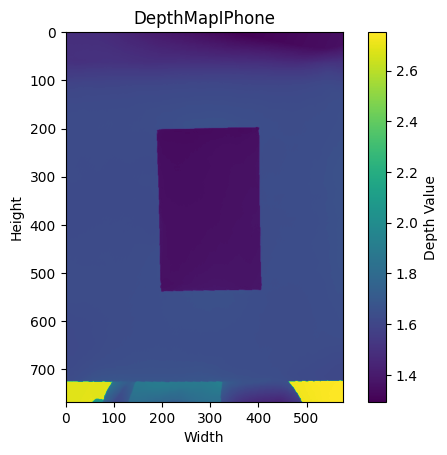

In [86]:
# plotting the depthmap
plt.imshow(depth_map_meters)
plt.colorbar(label="Depth Value")
plt.title("DepthMapIPhone")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

 Processing Depth Map

In [57]:
depth_map_meters

array([[4.41091765, 4.41091765, 4.41091765, ..., 4.8214902 , 4.8214902 ,
        4.8214902 ],
       [4.41091765, 4.41091765, 4.41091765, ..., 4.8214902 , 4.8214902 ,
        4.8214902 ],
       [4.39306667, 4.41091765, 4.41091765, ..., 4.8214902 , 4.8214902 ,
        4.8214902 ],
       ...,
       [0.64436078, 0.64436078, 0.64436078, ..., 0.448     , 0.448     ,
        0.448     ],
       [0.64436078, 0.64436078, 0.64436078, ..., 0.448     , 0.448     ,
        0.448     ],
       [0.64436078, 0.64436078, 0.64436078, ..., 0.448     , 0.448     ,
        0.448     ]])

Filterung

# Create RGBD image

 RGBD Image

In [58]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d_Iphone, depth_o3d_Iphone)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array

Comparison of RGB and depth map image

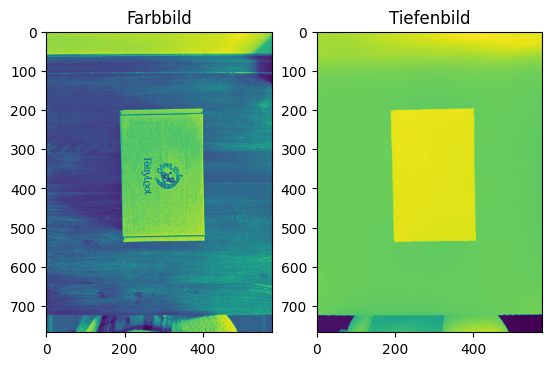

In [59]:
plt.subplot(1, 2, 1)
plt.title("Farbbild")
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title("Tiefenbild")
plt.imshow(rgbd.depth)
plt.show()

# Get camera intrinsics

With the intrinsics of the camera that took the photo we are able to correct distortions 

## OpenCV camera calibration

In [60]:
images = glob.glob(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Chesspattern\8x11_normalCamera\*.jpg") #checkerboard pictures for calibration

In [61]:
images

['C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8524.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8525.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8526.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8527.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8528.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8529.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x11_normalCamera\\IMG_8530.JPG',
 'C:\\Users\\Diren\\Nextcloud\\HTW\\4.Semester-Masterarbeit\\Masterarbeit\\Code\\Chesspattern\\8x

In [62]:
ret,mtx,dist,rvecs,tvecs, reprojection_error = get_camera_intrinsics(images)

because the depthmap image is 768x576 and i can´t calibrate the lidar sensor directly, i will scale the matrix (mtx) and distortion coefficients (dist) of the normal camera down. 

In [63]:
original_width, original_height = 3024, 4032

# sclaingfactor
scale_x = dm_width_Iphone / rgb_width_Iphone
scale_y = dm_height_Iphone / rgb_height_Iphone

# scaling
scaled_mtx = mtx.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[551.38085675   0.         402.29879443]
 [  0.         551.99205691 300.16257212]
 [  0.           0.           1.        ]]


## Exiftool camera calibration

intrinsische Matrix und distortion_coefficients via exif

In [64]:
mtx_exif = np.array([
    [2878.218994140625, 0.0, 1509.392333984375],
    [0.0, 2878.218994140625, 2012.1256],
    [0.0, 0.0, 1.0]
])


In [65]:
distortion_coefficients_exif = np.array([
    -0.35576209425926208,  # k1
    -0.0066862036474049091,  # k2
    0.0057414853945374489,  # p1
    -0.00049229874275624752,  # p2
    1.8682043446460739e-05,  # k3
    -3.3853208947220992e-07,  # k4
    2.383720332232997e-09   # k5
])

In [66]:
distortion_coefficients_exif = distortion_coefficients_exif[:5]

exif mxt anpassen

In [67]:
# sclaingfactor
scale_x = dm_width_Iphone / rgb_width_Iphone
scale_y = dm_height_Iphone / rgb_height_Iphone

# scaling
scaled_mtx_exif = mtx_exif.copy()
scaled_mtx_exif[0, 0] *= scale_x  # f_x
scaled_mtx_exif[1, 1] *= scale_y  # f_y
scaled_mtx_exif[0, 2] *= scale_x  # c_x
scaled_mtx_exif[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx_exif)

Angepasste intrinsische Matrix:
[[548.23218936   0.         287.50330171]
 [  0.         548.23218936 383.26201905]
 [  0.           0.           1.        ]]


because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [68]:
fx = scaled_mtx_exif[0, 0]
fy = scaled_mtx_exif[1, 1]
cx = scaled_mtx_exif[0, 2]
cy = scaled_mtx_exif[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_exif_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width_Iphone,height=dm_height_Iphone, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 548.232189360119, fy: 548.232189360119, cx: 287.5033017113095, cy: 383.26201904761905


unscaled intrinsic

In [69]:
fx = mtx_exif[0, 0]
fy = mtx_exif[1, 1]
cx = mtx_exif[0, 2]
cy = mtx_exif[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_exif = o3d.camera.PinholeCameraIntrinsic(width=dm_width_Iphone,height=dm_height_Iphone, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 2878.218994140625, fy: 2878.218994140625, cx: 1509.392333984375, cy: 2012.1256


# Create point cloud

In [70]:
#depth_array_Iphone = 255 - depth_array_Iphone  # Array umkehren

In [93]:
depth_data_uint16_Iphone = (depth_array_Iphone.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

In [97]:
depth_data_uint16_Iphone_scaled = (depth_map_meters * 1000).astype(np.uint16)  # Meter -> Millimeter
depth_uint16_o3d_Iphone_scaled = o3d.geometry.Image(depth_data_uint16_Iphone_scaled)


The PCD looks more accurate when scaling the intrinsic matrix first

## Point cloud only from depth image

PCD Iphone

In [98]:
depth_image_scaled = o3d.geometry.Image(depth_uint16_o3d_Iphone_scaled)


pcd_Iphone = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image_scaled,
    intrinsic=intrinsic_exif_scaled,
    depth_scale=1000.0,  # Werte sind in Millimetern
    depth_trunc=5000.0,  # Maximale Tiefe auf 5 Meter begrenzen
)


In [94]:

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

# Punktwolke aus Tiefenkarte erstellen
pcd_Iphone = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic=intrinsic_exif_scaled
    #depth_scale=1000.0,  # Skalierungsfaktor für Millimeter
    #depth_trunc=1000.0,  # Maximale Tiefe in Millimetern
)


In [99]:
o3d.visualization.draw_geometries([pcd_Iphone])

## Point cloud only from RGBD image

In [22]:
pcrgbd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_exif_scaled)
o3d.visualization.draw_geometries([pcrgbd])

# Clean Point Cloud

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [119]:
pcd_center = pcd_Iphone.get_center()
pcd_Iphone.translate(pcd_center)

PointCloud with 441283 points.

## Voxelization

In [121]:
#pcd_Iphone = pcd_Iphone.voxel_down_sample(voxel_size=0.0000005)
#o3d.visualization.draw_geometries([pcd_Iphone])

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [122]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [123]:
cl, ind = pcd_Iphone.remove_statistical_outlier(nb_neighbors=100, std_ratio=3.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [124]:
display_inlier_outlier(pcd_Iphone, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [125]:
# Cleaned PC
pcd_Iphone = pcd_Iphone.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [126]:
#o3d.visualization.draw_geometries([pcd_Iphone])

## Estimating normals

In [127]:
nn_distance = np.mean(pcd_Iphone.compute_nearest_neighbor_distance())

print(nn_distance)

0.00037481899657484333


In [128]:
radius_normals = nn_distance * 4

pcd_Iphone.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd_Iphone.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([pcd_Iphone])

## Multi RANSAC

In [60]:
front = [ -0.26316981750620544, 0.40283907551778914, 0.87661983002309707 ]
lookat = [ -0.11224615038136918, -0.0060122200969514247, 0.24006176520010536 ]
up = [ 0.75550742721619912, 0.65112664204123394, -0.072405962774251584 ]
zoom = 0.69999999999999996

In [61]:
pt_to_plane_dist = 0.028

plane_model, inliers = pcd_Iphone.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=20, num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd_Iphone.select_by_index(inliers)
outlier_cloud = pcd_Iphone.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], zoom=zoom, front=front, lookat=lookat, up=up)


Plane equation: -0.04x + 0.89y + 0.45z + -0.12 = 0


In [62]:
max_plane_idx = 6
pt_to_plane_dist = 0.02

segment_models = {}
segments = {}
rest = pcd_Iphone

for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=3, num_iterations=1000)
    segments[i] = rest.select_by_index(inliers)
    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert=True)
    print("pass", i, "/", max_plane_idx, "done.")

o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)] + [rest], zoom=zoom, front=front, lookat=lookat, up=up)


pass 0 / 6 done.
pass 1 / 6 done.
pass 2 / 6 done.
pass 3 / 6 done.


RuntimeError: [Open3D Error] (class std::tuple<class Eigen::Matrix<double,4,1,0,4,1>,class std::vector<unsigned __int64,class std::allocator<unsigned __int64> > > __cdecl open3d::geometry::PointCloud::SegmentPlane(const double,const int,const int,const double) const) D:\a\Open3D\Open3D\cpp\open3d\geometry\PointCloudSegmentation.cpp:175: There must be at least 'ransac_n' points.


## Plane segmentation with RANSAC

In [130]:
plane_model, inliers = pcd_Iphone.segment_plane(
    distance_threshold=0.01,
    ransac_n=10,
    num_iterations=6000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
inlier_cloud = pcd_Iphone.select_by_index(inliers)
inlier_cloud = inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd_Iphone.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
o3d.visualization.draw_geometries(
    [inlier_cloud, outlier_cloud])


In [ ]:
pcd_Iphone = outlier_cloud

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone], window_name="")

## SOR again

In [ ]:
#ggf. kann man für die restlichen punkte nun wieder SOR nutzen?
cl, ind = pcd_Iphone.remove_statistical_outlier(nb_neighbors=1000, std_ratio=3.0) 

In [ ]:
display_inlier_outlier(pcd_Iphone, ind)

In [ ]:
# Cleaned PC
pcd_Iphone = pcd_Iphone.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone])

## Hidden point removal

# Sonstiges/Tests

## DBSCAN-Clustering

In [ ]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_Iphone.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd_Iphone.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd_Iphone])

In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  # Ersetzen Sie dies durch die Cluster-ID des unerwünschten Clusters

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne das unerwünschte Cluster erstellen
remaining_cloud = pcd_Iphone.select_by_index(indices_to_remove, invert=True)

# Visualisierung der bereinigten Punktwolke
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")


## Convex Hull
Die Konvexe Hülle wird ggf. relevant für die Volumenberechnung, sobald ich nur das Zielobjekt extrahieren kann. Problem ist nur bei dieser Methode, dass bspw. runde Objekte überschätzt werden. 

In [ ]:
scale_factor = 1000  # Skalieren um den Faktor 1000 (z. B. mm -> m)
remaining_cloud.scale(scale_factor, center=remaining_cloud.get_center())

In [ ]:
# calculate hull
hull_mesh, hull_vertices = remaining_cloud.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([remaining_cloud, hull_ls])


In [ ]:
# Konvexe Hülle aus der Punktwolke berechnen
hull, _ = remaining_cloud.compute_convex_hull()

#Volumen der konvexen Hülle berechnen
volume = hull.get_volume()

print(f"Volumen der konvexen Hülle: {volume:.2f} Einheiten^3")

In [ ]:
bounds = remaining_cloud.get_max_bound() - remaining_cloud.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.2f}, y={bounds[1]:.2f}, z={bounds[2]:.2f}")


In [ ]:
print(f"Anzahl der Punkte in der konvexen Hülle: {len(hull.vertices)}")
print(f"Anzahl der Dreiecke in der konvexen Hülle: {len(hull.triangles)}")


In [ ]:
# Visualisierung der Hülle und Punktwolke
hull.paint_uniform_color([1, 0, 0])  # Hülle rot färben
o3d.visualization.draw_geometries([remaining_cloud, hull])

## Mesh
Ggf. auch interessant

## Interaktive PC

In [ ]:
# Punktwolke interaktiv anzeigen
print("Drücke 'Shift + Linksklick', um Punkte auszuwählen, und 'Shift + Rechtsklick', um Auswahl aufzuheben.")
picked_points = o3d.visualization.draw_geometries_with_editing([pcd])

# Ausgewählte Punkt-Indizes anzeigen
print(f"Ausgewählte Punkt-Indizes: {picked_points}")

In [ ]:
print(picked_points)

In [ ]:
import numpy as np

# Koordinaten der Punkte
point1 = np.array([-0.12, 0.0076, 0.24])  # Punkt 1 (#250552)
point2 = np.array([-0.034, -0.071, 0.16])  # Punkt 2 (#52765)

# Euklidische Distanz berechnen
distance = np.linalg.norm(point2 - point1)

# Ergebnis ausgeben
print(f"Abstand zwischen den Punkten: {distance:.6f} Einheiten")


weiteres

In [ ]:
# Punktkoordinaten abrufen
points = np.asarray(pcd_Iphone.points)

# Minimum und Maximum der Z-Achse (Tiefe) prüfen
min_z = np.min(points[:, 2])
max_z = np.max(points[:, 2])

print(f"Minimale Z-Tiefe: {min_z}")
print(f"Maximale Z-Tiefe: {max_z}")

In [ ]:
# unit of measurement herausfinden
depth_array_Iphone